In [2]:
import numpy as np
import re
from tqdm import tqdm
import math
from random import randint
 
vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics

# Read Data into Stuctures

In [3]:
# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
 
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1
 
# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids

docs_i = []

for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )


# Full LDA 

In [4]:
''' Creates a matrix of size [D, V] i.e Documents and Vocabulary'''
''' Indexing q[i][j] will give you doc i's and word j's topic assigment'''
''' Randoming assign each word for each document a random K (0 to K-1) topic'''
def randomly_assign_topics():
    qs = []
    c = np.zeros((D, V, K))
    for i in xrange(D):
        qs_i = []
        for l, hash_i in enumerate(docs_i[i]):
            k = randint(0, K-1)
            qs_i.append(k)
            c[i][hash_i][k] += 1
        qs.append(qs_i)
    
    return qs, c

                       
def compute_data_likelihood(qs, topics):
    likelihood = 0
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            k = qs[i][l]
            likelihood += math.log(topics[hash_i][k])
    return likelihood

def resample_qs(qs, c_vk, c_ik):
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            prob_dist = []
            total = 0
            for k in xrange(K):
                prob = pdtm[k][i] * topics[hash_i][k]
                total += prob
                prob_dist.append(prob)
            prob_dist = np.asarray(prob_dist) / total
            
            '''Resample new topic for word'''
            new_k = np.random.choice(K, p=prob_dist)
            '''Assign new k to work in document'''
            old_k = qs[i][l]
            qs[i][l] = new_k

            '''Update counts c_vk'''
            c_vk[hash_i][old_k] -=1
            c_vk[hash_i][new_k] +=1
            '''Update counts c_ik'''
            c_ik[i][old_k] -=1
            c_ik[i][new_k] +=1
                
    return qs, c_vk, c_ik


'''[Q], [c]'''
qs, c = randomly_assign_topics() #(472, 17675) 

'''Collect statistics'''
c_vk = np.sum(c, axis=0) #(17675, 10)
c_ik = np.sum(c, axis=1) #(472, 10)
c_k = np.sum(c_vk, axis=0) #(10,)
L_i = np.sum(c_ik, axis=1) #(472,) 

'''[alpha] [beta] hyperparameters'''
alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

'''[PI] For each document, dirichlet distribution over topics'''
# per-document-topic distributions: 
pdtm = np.zeros((K,D)) 
for i in xrange(D):
    pdtm[:,i] = np.random.dirichlet(alphas + c_ik[i])

'''[B] For each topic, dirichlet distribution over words/vocab'''
# topic distributions: 
topics = np.zeros((V,K))
for k in xrange(K):
    topics[:, k] =  np.random.dirichlet(gammas + c_vk[:,k])


full_gibbs_likelihoods = [] 
for iters in tqdm(range(0,5)):
    # compute data likelihood
    p = compute_data_likelihood(qs, topics)
    
    # store likelihood
    full_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-word topic assignments qs
    qs, c_vk, c_ik = resample_qs(qs, c_vk, c_ik)
 
    # resample per-document topic mixtures pdtm
    for i in xrange(D):
        pdtm[:,i] = np.random.dirichlet(alphas + c_ik[i])
        
    # resample topics
    for k in xrange(K):
        topics[:, k] =  np.random.dirichlet(gammas + c_vk[:,k])
        
        

100%|██████████| 5/5 [02:57<00:00, 35.36s/it]


## Collapsed Gibbs Sampling for LDA

In [15]:
def resample_topic_collaspsed(qs, docs_i, c_vk, c_ik, c_k):
    for i in xrange(D):
        for l, hash_i in enumerate(docs_i[i]):
            total = 0
            prob_dist = []
            for k in xrange(K):
                prob = (c_vk[hash_i][k] / (c_k[k] + V)) * (c_ik[i][k] / (L_i[i] + K))
                total += prob
                prob_dist.append(prob)
            prob_dist = np.asarray(prob_dist) / total
            
            '''Resample new topic for word'''
            new_k = np.random.choice(K, p=prob_dist)
            '''Assign new k to work in document'''
            old_k = qs[i][l]
            qs[i][l] = new_k

            '''Update counts c_vk'''
            c_vk[hash_i][old_k] -=1
            c_vk[hash_i][new_k] +=1
            '''Update counts c_ik'''
            c_ik[i][old_k] -=1
            c_ik[i][new_k] +=1
            '''Update counts c_k'''
            c_k[old_k] -=1
            c_k[new_k] +=1
                
    return qs, c_vk, c_ik, c_k

qs, c = randomly_assign_topics() 

#collect statistics
c_vk = np.sum(c, axis=0) #(17675, 10)
c_ik = np.sum(c, axis=1) #(472, 10)
c_k = np.sum(c_vk, axis=0) #(10,)
L_i = np.sum(c_ik, axis=1) #(472,) #never changes

# topic distributions: 
topics_ = np.zeros((V,K))
for k in xrange(K):
    topics_[:, k] =  np.random.dirichlet(gammas + c_vk[:,k])
    
collapsed_gibbs_likelihoods = []
for iters in tqdm(range(0,5)):
    
    # compute data likelihood
    p = compute_data_likelihood(qs, topics_)
    
    #store likelihood
    collapsed_gibbs_likelihoods.append(p)
    
    #print "Iter %d, p=%.2f" % (iters,p)
    
    # resample per-word topic assignments qs
    qs, c_vk, c_ik, c_k = resample_topic_collaspsed(qs, docs_i, c_vk, c_ik, c_k)
    
     # resample topics - just for the likelihood
    for k in xrange(K):
        topics_[:, k] =  np.random.dirichlet(np.ones(V) + c_vk[:,k])
    


100%|██████████| 5/5 [03:46<00:00, 45.52s/it]


-5342536.27049


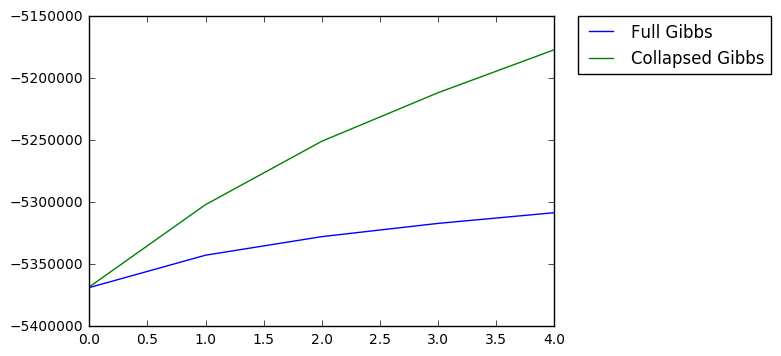

In [16]:
import matplotlib.pyplot as plt
full_gibbs_likelihoods[0]
test = full_gibbs_likelihoods[1:]
print test[0]
plt.plot(range(5), full_gibbs_likelihoods, label='Full Gibbs')
plt.plot(range(5), collapsed_gibbs_likelihoods, label='Collapsed Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

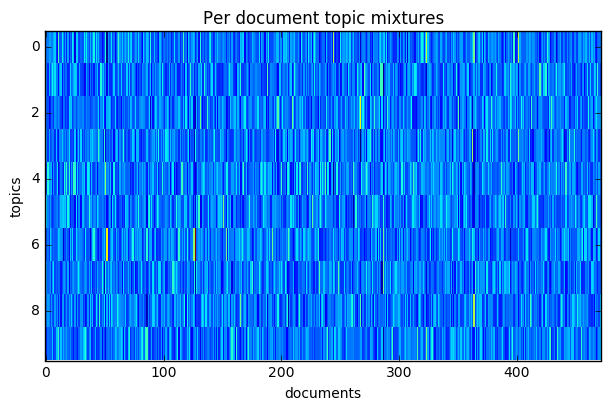

In [17]:

#pdtm = np.zeros((K,D)) 
# %pylab inline
# pylab.rcParams['figure.figsize'] = (8.0, 8.0)

plt.figure()
plt.imshow(pdtm, interpolation='nearest', cmap='jet', aspect='auto')
plt.title("Per document topic mixtures")

plt.tight_layout()
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()
